In [3]:
import numpy as np

Loading text data for RNN

In [4]:
text_data = "abc " # input data
# txt_data = open('input.txt', 'r').read() # test external files

chars = list(set(text_data)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
num_data_size = len(text_data)

print("unique characters : ", num_chars) # You can see the number of unique characters in your input data.
print("txt_data_size : ", num_data_size)

unique characters :  4
txt_data_size :  4


In [6]:
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in text_data] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'b': 0, 'a': 1, ' ': 2, 'c': 3}
----------------------------------------------------
{0: 'b', 1: 'a', 2: ' ', 3: 'c'}
----------------------------------------------------
[1, 0, 3, 2]
----------------------------------------------------
data length :  4


In [7]:
iteration = 10
sequence_length = 5
batch_size = round((num_data_size /sequence_length)+0.5) # = math.ceil
hidden_size =2  # size of hidden layer of neurons.  
learning_rate = 0.01


# model parameters


W_xh = np.array([[0.1, 0.1, 0.1, 0.1],[0.1, 0.1, 0.1, 0.1]])     # weight input -> hidden. 
print("W_xh ",W_xh)
W_hh = np.array([0.1,0.1,0.1,0.1])    # weight hidden -> hidden
W_hh = np.reshape(W_hh,(2,2))
print("W_hh ",W_hh)
W_hy = np.array([[0.1, 0.1, 0.1, 0.1],[0.1, 0.1, 0.1, 0.1]])     # weight hidden -> output
W_hy = np.reshape(W_hy,(4,2))
print("W_hy ",W_hy)

b_h = np.zeros((hidden_size, 1)) # hidden bias
print("b_h ",b_h)
b_y = np.zeros((num_chars, 1)) # output bias
print("b_y ",b_y)
h_prev = np.zeros((hidden_size,1)) # h_(t-1)
print("h_prev ",h_prev)

W_xh  [[0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1]]
W_hh  [[0.1 0.1]
 [0.1 0.1]]
W_hy  [[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
b_h  [[0.]
 [0.]]
b_y  [[0.]
 [0.]
 [0.]
 [0.]]
h_prev  [[0.]
 [0.]]


In [8]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
#         print("xs[",t,"] ",xs[t])
        xs[t][inputs[t]] = 1
#         print("xs[",t,"] ",xs[t])
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
#         print("hs[",t,"] ",hs[t])
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
#         print("ys[",t,"] ",ys[t])
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
#         print("ps[",t,"] ",ps[t])
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code
#         print("loss ",loss)

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs 

In [9]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
#     print("dWxh ",dWxh)
#     print("dWhh ",dWhh)
#     print("dWhy ",dWhy)
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
#     print("dbh ",dbh)
#     print("dby ",dby)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 
#     print("dhnext ",dhnext)

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

In [10]:
LOSS = []

In [11]:
data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 


for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in text_data[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in text_data[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(text_data) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    #if i % 100 == 0:
    print ('iter %d, loss: %f' % (i+1, loss)) # print progress
    LOSS.append(loss)

iter 1, loss: 5.545177
iter 2, loss: 5.519996
iter 3, loss: 5.499946
iter 4, loss: 5.481137
iter 5, loss: 5.462959
iter 6, loss: 5.445246
iter 7, loss: 5.427882
iter 8, loss: 5.410816
iter 9, loss: 5.394015
iter 10, loss: 5.377457


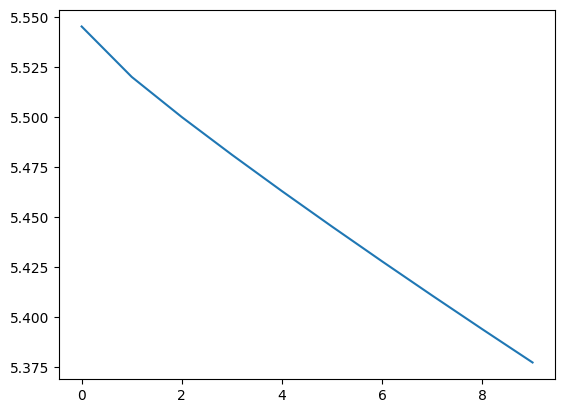

In [12]:
import matplotlib.pyplot as plt
plt.plot(LOSS)